# **PneumoniaMNIST with Quanvolution 2×2 - GPU**
### *Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Autor: **Sebastián González Juárez**

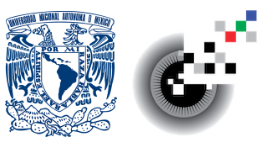

### **Resumen:**

Este código es continuación al documento PneumoniaMNIST_with_Quanvolution_2×2.

La nueva versión es un modelo cuántico en GPU que reemplaza por completo la implementación lenta del CPU al transformar la operación fundamental de la quanvolución: antes, cada parche 2×2 se procesaba uno por uno mediante un QNode ejecutado **784 veces por imagen**, lo que generaba miles de llamadas al simulador y hacía que una época tardara horas o días. En la nueva versión, todos los parches se **apilan en un solo tensor gigante** y se procesan simultáneamente mediante un QNode **vectorizado** en `default.qubit.torch`, donde las rotaciones, CNOTs y mediciones se aplican a cientos de miles de estados en paralelo utilizando kernels CUDA. 

Además, se elimina la reducción 28→14 para que la cuanvolución opere con stride=1 (SAME-28), lo cual mantiene resolución completa y aprovecha mejor el paralelismo. Con esto, el entrenamiento pasa de días a segundos por época, los gradientes fluyen directamente vía *backprop* en GPU, y se evita por completo el bucle Python que hacía el modelo original inusable.

Sugiero enormemente, para una mejor comprensión del código, haber leído el documento anterior y sus 6 versiones de código, pues no genere explicación a detalle de este código. Lo haré en el siguiente proyecto. 

**Resultados**:

La velocidad de código aumento y se logro hacer la base para los siguientes proyectos más grandes, ahora si es escalable. 
La presición de las versiones anteriores es mejor, sin embargo es por aproximadamente 3% de presición asu modelo más parecido. 

Al realizar la comparación con un modelo clásico (sin la parte cuántica) este modelo esta por debajo del modelo cuántico:
* El modelo clásico tuvo 86.5% contra 87.7% del cuántico para el umbral thr=0.500.
* El modelo clásico tuvo 84.5% contra 85.6% del cuántico con umbral restaurado de thr=0.351 y thr=0.294 respectivamente.

### Importaciones y paqueterías:

Para las secciones de cómputo clásico, utilizaremos las siguientes paqueterías ya conocidas y nuestro conjunto de datos a estudiar:

In [1]:
import numpy as np, time, random, math
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score, roc_curve, f1_score
)

Utilizaremos PennyLane para construir el circuito cuántico variacional que se integran con PyTorch:

In [2]:
import pennylane as qml

Fijamos la semilla:

In [3]:
SEED = 87
np.random.seed(SEED); random.seed(SEED)

Chequeos del GPU:

In [4]:
assert torch.cuda.is_available(), "Se requiere GPU con CUDA habilitada."
torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)     # clave: todo float en float32
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True      # acelera kernels conv

DEVICE = torch.device("cuda:0")
print(f"[GPU] {torch.cuda.get_device_name(0)} | default_dtype={torch.get_default_dtype()}")

[GPU] NVIDIA GeForce RTX 3090 | default_dtype=torch.float32


# **1) Hiperparámetros y configuración.**

El conjunto PneumoniaMNIST es binario y se define como:  0 = sano, 1 = neumonía.

In [5]:
CLASS_POS = 1; CLASS_NEG = 0

BATCH_SIZE es el número de imágenes procesadas en paralelo, para esta versión se puede aumentar demasiado. Lo deje en 64 para seguir con la comparación sin irnos tan lejos. 

In [6]:
BATCH_SIZE   = 64

EPOCHS son las pasadas completas sobre el conjunto de entrenamiento, igualmente para esta versión podemos exagerar, pues tarda menos de 15 segundos por época. 

**Nota**: En las versiones anteriores tardabamos alrededor de una semana en correr 12 épocas, ahora podemos hacer eso en 3 minutos, solo cuida el sobre ajuste.

In [7]:
EPOCHS       = 20

LR es el learning rate, la cual es la tasa de actualización para todos los parámetros (cuánticos y clásicos). Lo escogí en base al análisis que hice en los 6 códigos anteriores.

In [8]:
LR           = 3.5e-5

WEIGHT_DECAY es la regularización L2 y recordemos que busca controlar si hay sobreajuste, demasiada penalización frena el aprendizaje.

In [9]:
WEIGHT_DECAY = 1e-5

PATCH_SIZE es el tamaño del parche que se mapea al circuito cuántico. Aquí usamos 2×2 → 4 qubits.

**Nota**: No he probado una quanvolución más grande, pero si en futuro probare a 3×3 (9 qubits) o 4×4 (16 qubits), el costo del simulador crecerá exponencialmente (∝ 2^qubits) y la memoria también.

In [10]:
PATCH_SIZE   = 2

QUBITS = PATCH_SIZE * PATCH_SIZE no describo justamente el núm. de Qubits por parche y para 2×2 es 4.

In [11]:
QUBITS       = PATCH_SIZE * PATCH_SIZE    # = 4

LAYERS son las capas del ansatz variacional que se repiten (bloques RY/RZ + CNOT ring). Lo dejaré igual para compara.

In [12]:
LAYERS       = 2                          # capas del ansatz VQA

DIFF_METHOD es el método de diferenciación del QNode. Este es el primer gran cambio que econtraremos, pues recordemos que las otras versiones usaban adjoint.

Usamos "backprop" porque el backend es default.qubit.torch (GPU), lo que permite que PyTorch autograd propague gradientes a través del simulador cuántico.

In [13]:
DIFF_METHOD  = "backprop"                 # default.qubit.torch

SHOTS es el número de disparos/mediciones, vamos a dejarlo en None para seguir con la comparación.

Recordemos que de este modo la expectativa es exacta (sin ruido de muestreo), diferenciable y más rápida en simulación.

Al poner un entero (p. ej. 1 024) introduces estocasticidad y costo adicional.

In [14]:
SHOTS        = None                       # expectativas exactas

DROPOUT_P es la probabilidad de apagado en la cabeza clásica (MLP), vamos a dejarla igual.

In [15]:
DROPOUT_P    = 0.20

OUT_DIM es la dimensión del logit de salida, para binario es 1 y luego se aplica sigmoide en métricas.

In [16]:
OUT_DIM      = 1

# **2) Preparación y carga de datos (MedMNIST: PneumoniaMNIST):**

Vamos a usar torchvision.transforms para convertir cada imagen de PIL/numpy a tensor torch.FloatTensor en rango [0,1]. Luego Descarga automáticamente los tres subconjuntos:
* Entrenamiento (train)
* Validación (val)
* Prueba (test)

Resultando en que cada imagen tiene la forma de (1, 28, 28) (1 canal, escala de grises).

In [17]:
tf = transforms.Compose([transforms.ToTensor()])
train_set = PneumoniaMNIST(split='train', transform=tf, download=True)
val_set   = PneumoniaMNIST(split='val',   transform=tf, download=True)
test_set  = PneumoniaMNIST(split='test',  transform=tf, download=True)

Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz


La función auxiliar to_tensors(ds) transforma el dataset en dos tensores puros (imágenes y etiquetas).
* Entradas: un objeto de tipo PneumoniaMNIST.
* Salidas: xs: imágenes (N,1,28,28) y ys: etiquetas (N,)

Ambos en CPU (es importante mantenerlos ahí para el DataLoader con pin_memory=True). El motivo del .to('cpu') es que las imágenes se cargan y se fijan en CPU antes de que el DataLoader las “pinee” (fije en memoria paginada) para luego transferirlas a GPU rápidamente en cada batch.

In [18]:
def to_tensors(ds):
    xs = torch.stack([
        (ds[i][0] if isinstance(ds[i][0], torch.Tensor) else torch.as_tensor(ds[i][0]))
        .to('cpu').float()
        for i in range(len(ds))
    ], dim=0)  # (N,1,28,28)
    ys = torch.tensor([
        (ds[i][1].item() if hasattr(ds[i][1], "item") else np.asarray(ds[i][1]).item())
        for i in range(len(ds))
    ], dtype=torch.long, device='cpu')     # (N,)
    return xs, ys

X_tr, y_tr = to_tensors(train_set)
X_va, y_va = to_tensors(val_set)
X_te, y_te = to_tensors(test_set)

Otro gran cambio es que no usaremos shuffle como lo hicimos antes, usaremos torch.Generator para generar la aleatoriedad de los batches y que sea reproducible usando la semilla del dispositivo CUDA y no del CPU.

In [19]:
g_cuda = torch.Generator(device=DEVICE); g_cuda.manual_seed(SEED)

Ahora pasemos a la construcción de los tres DataLoaders (train, val, test) y se crean con parámetros diseñados para máximo rendimiento en GPU local:

In [20]:
num_w = 4
train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=BATCH_SIZE, shuffle=True, generator=g_cuda,
    num_workers=num_w, pin_memory=True, persistent_workers=(num_w>0)
)
val_loader   = DataLoader(
    TensorDataset(X_va, y_va),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_w, pin_memory=True, persistent_workers=(num_w>0)
)
test_loader  = DataLoader(
    TensorDataset(X_te, y_te),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=num_w, pin_memory=True, persistent_workers=(num_w>0)
)

Veamos las dimensiones de los subconjuntos y el tamaño del primer lote:

In [21]:
print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")
print("Ejemplo shape batch:", next(iter(train_loader))[0].shape)

Train: 4708 | Val: 524 | Test: 624
Ejemplo shape batch: torch.Size([64, 1, 28, 28])


Visualicemos el conjunto de imágenes:

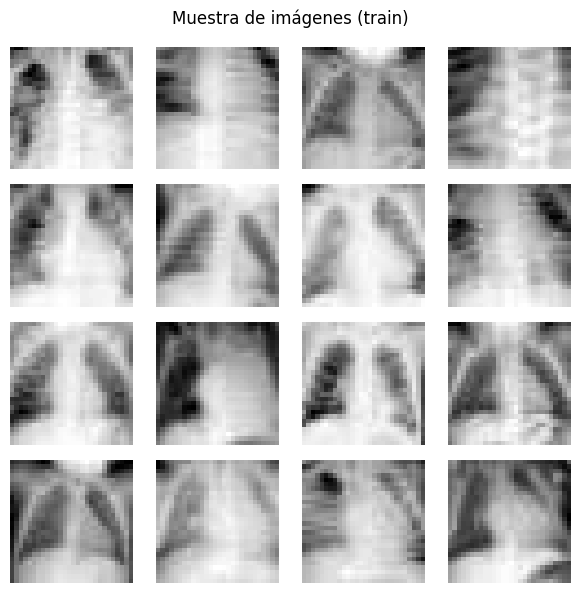

In [22]:
imgs, ys = next(iter(train_loader))
fig, axs = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(imgs[i,0].numpy(), cmap='gray'); ax.axis('off')
plt.suptitle("Muestra de imágenes (train)"); plt.tight_layout(); plt.show()

# **3. Dispositivo y QNode (GPU, backprop, sin shots)**

En esta sección tenemos el mayor cambio, pues ahora fijamos el simulador cuántico en GPU y definimos un QNode vectorizado que procesa muchos parches 2×2 a la vez (broadcasting). El objetivo es que tanto el forward como los gradientes se calculen dentro de PyTorch en CUDA, evitando bucles Python y llamadas repetidas al QNode.

Tengo toda la intensión de traer está idea con mayor explicación y más desarrollada en el siguiente proyecto.

Primero vamos voy a asegurar que trabajamos con parches 2×2 (4 píxeles → 4 qubits). Si cambias el PATCH_SIZE, esta afirmación te obliga a revisar el circuito.

In [23]:
assert QUBITS == 4, "Para 28×28 sin reducción usamos patches 2×2 (QUBITS=4)."

Vamos a crear el simulador de estado de PennyLane respaldado por tensores de PyTorch en GPU. Esto permite que autograd calcule derivadas directamente en CUDA.

Nuevamente, en el siguiente proyecto pienso retomar está idea y la explicaré a más detalle este tipo de simulación de qubit con su interfaz y su método para calcular las derivadas.

In [24]:
dev = qml.device("default.qubit.torch", wires=QUBITS, shots=SHOTS, torch_device="cuda:0")

La contrucción de el VQA sigue siendo muy similar, donde autograd (más adelante) propaga gradientes a los θ cuánticos: weights[l, w, {0,1}] (RY/RZ por qubit y capa).

In [25]:
@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
def quanv_circuit_batched(x_angles_b, weights):
    # Encoding (broadcast)
    for w in range(QUBITS):
        qml.RY(x_angles_b[:, w], wires=w)
    # Ansatz compartido
    for l in range(LAYERS):
        for w in range(QUBITS):
            qml.RY(weights[l, w, 0], wires=w)
            qml.RZ(weights[l, w, 1], wires=w)
        qml.CNOT([0,1]); qml.CNOT([1,2]); qml.CNOT([2,3]); qml.CNOT([3,0])
    # Medición
    return (qml.expval(qml.PauliZ(0)),
            qml.expval(qml.PauliZ(1)),
            qml.expval(qml.PauliZ(2)),
            qml.expval(qml.PauliZ(3)))

La idea de la ventaja de la GPU es que en lugar de llamar al QNode 784 veces por imagen (uno por parche), pasamos todos los parches juntos en un gran tensor (Npatches, 4). PennyLane hace broadcasting interno: una sola traza del grafo aplica las mismas puertas a N copias del estado, con parámetros de entrada distintos. Resultado: 1 o pocas llamadas al QNode por batch (según chunking de la Sección 4), no miles.

# **4) Capas quanvolucionales 2×2 (vectorizada)**

Comentare de forma breve el funcionamiento de está capa, espero traerla pronto en el siguiente proyecto. 
    
Otro gran cambio que decidí hacer acá fue cambiar a stride=1, pues así podemos aprovechar al 100% la vectorización en GPU generando los parches solapados:
* Con stride=2, cada imagen solo produce 196 parches. (versiones anteriores)
* Con stride=1, cada imagen produce 784 parches.

Si entendimos la idea explicada en el código de CPU, entenderemos que en aunque en ambos tenemos la misma entrada, en este caso tenemos diferente salida:
* CPU (stride=2) -> (4,14,14)
* GPU (stride=1) -> (4,28,28)

Donde recordemos que cada uno de los 4 canales es la expectativa ⟨Z⟩ de un qubit tras el ansatz.

In [26]:
class Quanv2x2_28(nn.Module):
    def __init__(self, chunk_patches: int | None = 16384):
        super().__init__()
        self.weights = nn.Parameter(0.1 * torch.randn(LAYERS, QUBITS, 2, device=DEVICE))
        self._dbg_printed = False
        self.chunk = chunk_patches

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == 1 and H == 28 and W == 28, "Esperaba (B,1,28,28)."

        # SAME-28: pad derecha/abajo y stride=1 → 28*28 parches por imagen
        xpad = F.pad(x, (0,1,0,1), mode="constant", value=0.0)      # (B,1,29,29)
        patches = F.unfold(xpad, kernel_size=2, stride=1)           # (B,4, 28*28)
        patches = patches.transpose(1, 2).reshape(-1, 4)            # (B*784, 4)
        angles  = torch.pi * patches                                # (Npatches, 4)

        # QNode vectorizado (en chunks si hace falta VRAM)
        if self.chunk is None:
            m0, m1, m2, m3 = quanv_circuit_batched(angles, self.weights)
            outs = torch.stack([m0, m1, m2, m3], dim=1)             # (Npatches, 4)
        else:
            outs_list = []
            N = angles.shape[0]
            for s in range(0, N, self.chunk):
                a = angles[s:s+self.chunk]
                m0, m1, m2, m3 = quanv_circuit_batched(a, self.weights)
                outs_list.append(torch.stack([m0, m1, m2, m3], dim=1))
            outs = torch.cat(outs_list, dim=0)

        # Reconstrucción espacial
        outs = outs.view(B, 28*28, 4).permute(0, 2, 1).contiguous().view(B, 4, 28, 28)
        outs = outs.to(x.dtype)  # f32

        if not self._dbg_printed:
            print(f"[Quanv] out: {outs.shape}, dtype={outs.dtype}, chunk={self.chunk}")
            self._dbg_printed = True
        return outs

# **5) Cabeza clásicas: Flatten + MLP**
La cabeza clásica es exactamente igual, sin embargo ahora tenemos 3136 salidas del aplanado, pues 4x28x28=3136.

In [27]:
class HeadSmall(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.hidden  = nn.Linear(4*28*28, 64)  # 3136 → 64
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc      = nn.Linear(64, OUT_DIM)  # 64 → 1

    def forward(self, z):
        z = z.reshape(z.shape[0], -1)          # (B,3136)
        z = F.relu(self.hidden(z))
        z = self.dropout(z)
        return self.fc(z)                      # (B,1)

# **6) Ensamble del modelo**

El ensamble es igual muy similar pero en este caso solo tenemos un único modelo sin reducción, evidentemente ahora tendremos muchos más parámetros. 

In [28]:
class QuanvModel(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.quanv = Quanv2x2_28(chunk_patches=16384)  # pon None si tu VRAM lo permite
        self.head  = HeadSmall(p_dropout=p_dropout)

    def forward(self, x):
        zq = self.quanv(x)       # (B,4,28,28)
        return self.head(zq)     # (B,1)

def build_model(p_dropout=DROPOUT_P):
    return QuanvModel(p_dropout=p_dropout).to(DEVICE)

model = build_model()
print("Modelo: 28×28 (Quanv2x2_28 SAME + Head 28×28)")
print("Parámetros totales:", sum(p.numel() for p in model.parameters()))

Modelo: 28×28 (Quanv2x2_28 SAME + Head 28×28)
Parámetros totales: 200849


# **7) Entrenamiento.**

Nuevamente todo muy similar a sus verisiones anteriores, hay algunos cambios para registrar los cambios en los parámetros cuánticos.

In [29]:
with torch.no_grad():
    n_pos = int((y_tr == 1).sum()); n_neg = int((y_tr == 0).sum())
pos_weight_val = n_neg / max(1, n_pos)
print(f"[Info] pos_weight (train): {pos_weight_val:.3f}  (pos={n_pos}, neg={n_neg})")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=DEVICE, dtype=torch.float32)
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def train_epoch(dloader, print_every=20):
    model.train()
    tot_loss, tot_acc, tot_n = 0.0, 0.0, 0
    t0 = time.time()
    for it, (xb, yb) in enumerate(dloader, start=1):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        preds = (logits.detach() >= 0).float()
        acc   = (preds == yb).float().mean().item()

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_acc  += acc * B
        tot_n    += B

        if it % print_every == 0:
            print(f"   · progreso: {tot_n} muestras (época en {time.time()-t0:.1f}s)")
    return tot_loss / max(1, tot_n), tot_acc / max(1, tot_n)

@torch.no_grad()
def _best_threshold(y_true, probs):
    try:
        fpr, tpr, thr = roc_curve(y_true, probs)
        j = tpr - fpr
        return float(thr[int(np.argmax(j))])
    except Exception:
        return 0.5

@torch.no_grad()
def eval_epoch(dloader):
    model.eval()
    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []
    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)
        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)
        B = xb.size(0)
        tot_loss += loss.item() * B; tot_n += B
        logits_all.append(logits.detach().cpu()); y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / max(1, tot_n)
    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()

    thr_star = _best_threshold(y_true, probs)
    y_hatS   = (probs >= thr_star).astype(np.int32)
    accS     = (y_hatS == y_true).mean()
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')
    f1S     = f1_score(y_true, y_hatS)

    y_hat05 = (probs >= 0.5).astype(np.int32)
    acc05   = accuracy_score(y_true, y_hat05)
    f105    = f1_score(y_true, y_hat05)

    return avg_loss, accS, auc, f1S, thr_star, acc05, f105

# --- Historial de métricas y de parámetros cuánticos ---
history = {
    "tr_loss": [], "tr_acc05": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [],  "va_f105": []
}
# Guardaremos un snapshot por época del tensor de pesos (LAYERS,4,2)
history_theta = []  # lista de tensores CPU con copia de model.quanv.weights

best_val_loss = float('inf'); best_state = None; best_thr_val = 0.5

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(train_loader)
    va_loss, va_acc_thr, va_auc, va_f1_thr, thr_star, va_acc05, va_f105 = eval_epoch(val_loader)

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state    = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_thr_val  = thr_star

    history["tr_loss"].append(tr_loss);     history["tr_acc05"].append(tr_acc)
    history["va_loss"].append(va_loss);     history["va_auc"].append(va_auc)
    history["va_acc_thr"].append(va_acc_thr); history["va_f1_thr"].append(va_f1_thr)
    history["va_thr"].append(thr_star);     history["va_acc05"].append(va_acc05)
    history["va_f105"].append(va_f105)     # ← aquí estaba el error

    # snapshot de parámetros cuánticos (para la Sección 9)
    history_theta.append(model.quanv.weights.detach().cpu().clone())

    print(f"Época {ep:02d} | "
          f"Train: loss={tr_loss:.4f}, acc@0.5={tr_acc*100:.1f}% | "
          f"Val: loss={va_loss:.4f}, acc@thr*={va_acc_thr*100:.1f}%, AUC={va_auc:.3f}, F1={va_f1_thr:.3f}, thr*={thr_star:.3f} "
          f"| Val@0.5: acc={va_acc05*100:.1f}%, F1={va_f105:.3f}")

# Restaurar mejor estado (para gráficas y test)
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f"[Info] Mejor estado restaurado (val_loss={best_val_loss:.4f}, thr*={best_thr_val:.3f})")

[Info] pos_weight (train): 0.347  (pos=3494, neg=1214)
[Quanv] out: torch.Size([64, 4, 28, 28]), dtype=torch.float32, chunk=16384
   · progreso: 1280 muestras (época en 5.8s)
   · progreso: 2560 muestras (época en 10.3s)
   · progreso: 3840 muestras (época en 14.7s)
Época 01 | Train: loss=0.2972, acc@0.5=81.1% | Val: loss=0.2474, acc@thr*=91.4%, AUC=0.954, F1=0.941, thr*=0.442 | Val@0.5: acc=82.4%, F1=0.869
   · progreso: 1280 muestras (época en 4.7s)
   · progreso: 2560 muestras (época en 9.4s)
   · progreso: 3840 muestras (época en 14.0s)
Época 02 | Train: loss=0.2127, acc@0.5=90.4% | Val: loss=0.1855, acc@thr*=93.7%, AUC=0.973, F1=0.957, thr*=0.442 | Val@0.5: acc=89.7%, F1=0.927
   · progreso: 1280 muestras (época en 5.0s)
   · progreso: 2560 muestras (época en 10.0s)
   · progreso: 3840 muestras (época en 15.0s)
Época 03 | Train: loss=0.1651, acc@0.5=92.2% | Val: loss=0.1499, acc@thr*=94.3%, AUC=0.976, F1=0.961, thr*=0.468 | Val@0.5: acc=92.7%, F1=0.950
   · progreso: 1280 muestras

##  Gráficas de pérdida y accuracy (Train/Val)

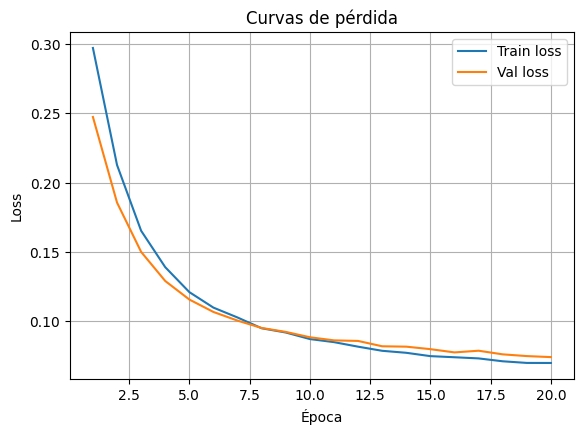

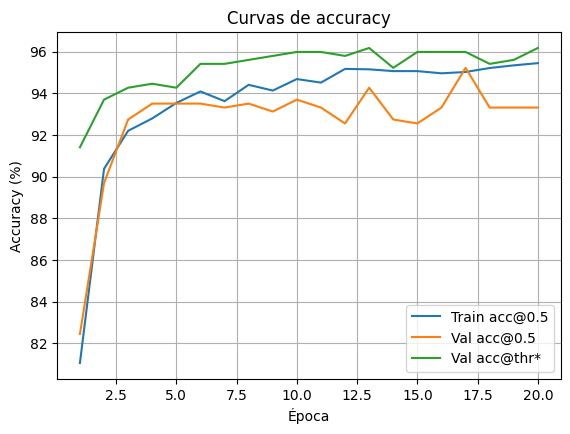

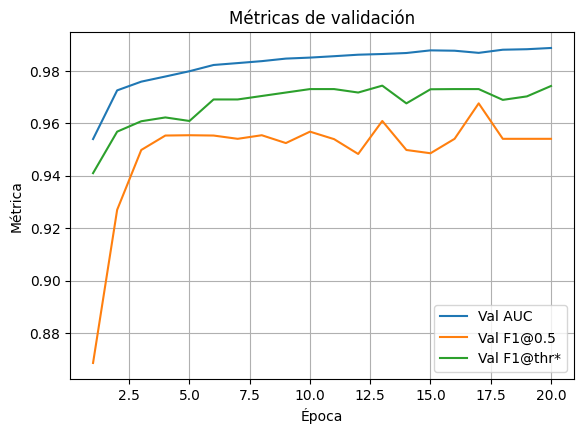

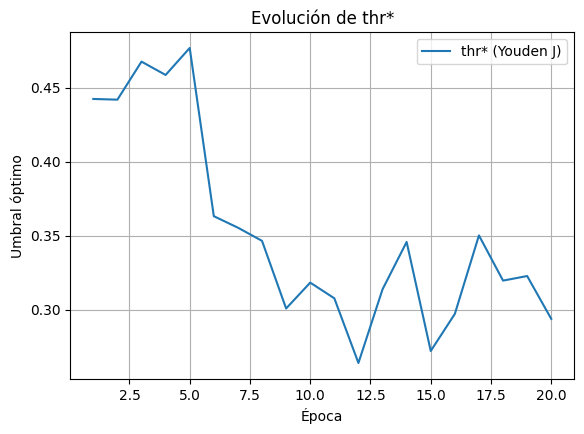

In [30]:
ep = np.arange(1, len(history["tr_loss"]) + 1)

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["tr_loss"], label="Train loss")
plt.plot(ep, history["va_loss"], label="Val loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curvas de pérdida")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, np.array(history["tr_acc05"])*100, label="Train acc@0.5")
plt.plot(ep, np.array(history["va_acc05"])*100, label="Val acc@0.5")
plt.plot(ep, np.array(history["va_acc_thr"])*100, label="Val acc@thr*")
plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title("Curvas de accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["va_auc"],    label="Val AUC")
plt.plot(ep, history["va_f105"],   label="Val F1@0.5")
plt.plot(ep, history["va_f1_thr"], label="Val F1@thr*")
plt.xlabel("Época"); plt.ylabel("Métrica"); plt.title("Métricas de validación")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["va_thr"], label="thr* (Youden J)")
plt.xlabel("Época"); plt.ylabel("Umbral óptimo"); plt.title("Evolución de thr*")
plt.legend(); plt.grid(True); plt.show()

# **8) Evaluación en TEST (umbrales: 0.5 y thr'*' de validación)**

Igual lo mismo para Test.

In [31]:
@torch.no_grad()
def eval_test_fixed(dloader, threshold):
    model.eval()
    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)
        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)
        B = xb.size(0); tot_loss += loss.item() * B; tot_n += B
        logits_all.append(logits.detach().cpu()); y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / max(1, tot_n)
    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()
    y_hat  = (probs >= float(threshold)).astype(int)

    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    auc  = roc_auc_score(y_true, probs)
    prau = average_precision_score(y_true, probs)
    cm   = confusion_matrix(y_true, y_hat)
    rep  = classification_report(y_true, y_hat, target_names=["Sano(0)", "Neumonía(1)"], zero_division=0)

    return {"loss": avg_loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1,
            "auc": auc, "prauc": prau, "cm": cm, "report": rep, "thr": float(threshold)}

def _print_test_result(tag, res):
    print(f"\n[TEST {tag}] thr={res['thr']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.1f}% | "
          f"precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['prauc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("\nReporte por clase:\n", res["report"])

# Asegurar mejor estado cargado
if 'best_state' in globals() and best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f"[Info] Mejor estado restaurado (val_loss={best_val_loss:.4f}, thr*={best_thr_val:.3f})")

res_05 = eval_test_fixed(test_loader, 0.5)
res_ts = eval_test_fixed(test_loader, best_thr_val)
_print_test_result("@0.5", res_05)
_print_test_result("@thr*", res_ts)


[Info] Mejor estado restaurado (val_loss=0.0738, thr*=0.294)

[TEST @0.5] thr=0.500
loss=0.3093 | acc=87.7% | precision=0.863 | recall=0.954 | F1=0.906
AUC=0.922 | PR-AUC=0.910
Matriz de confusión:
 [[175  59]
 [ 18 372]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.91      0.75      0.82       234
 Neumonía(1)       0.86      0.95      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624


[TEST @thr*] thr=0.294
loss=0.3093 | acc=85.6% | precision=0.823 | recall=0.979 | F1=0.895
AUC=0.922 | PR-AUC=0.910
Matriz de confusión:
 [[152  82]
 [  8 382]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.95      0.65      0.77       234
 Neumonía(1)       0.82      0.98      0.89       390

    accuracy                           0.86       624
   macro avg       0.89      

# **9)  Evolución de parámetros cuánticos (ansatz)**

Con esta nueva sección pretendo luego sacar más información cuando tengamos más parámetros cuánticos y debamos estudiar a más detalle los cambios. 

Por el momento dejare la base de futuros códigos. 

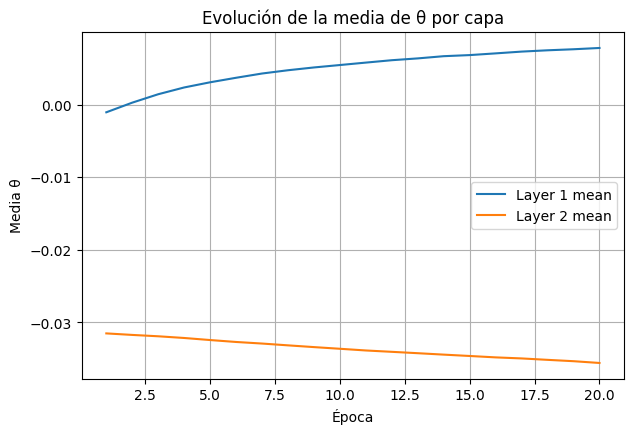

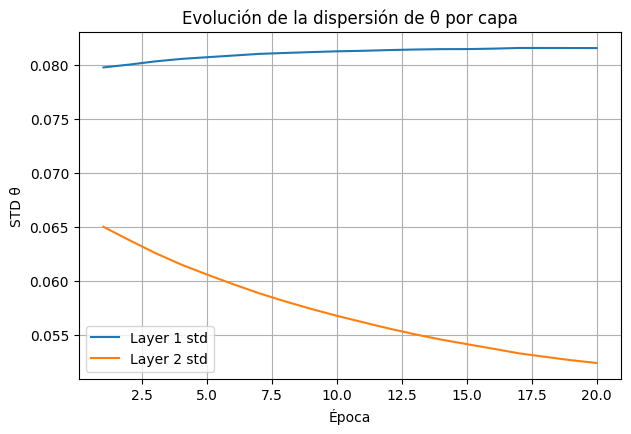

C:\Users\lapic\AppData\Local\Temp\ipykernel_23180\3480303517.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


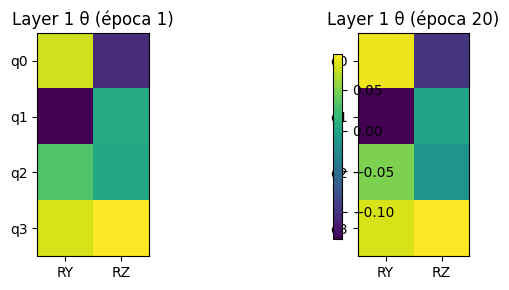

C:\Users\lapic\AppData\Local\Temp\ipykernel_23180\3480303517.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


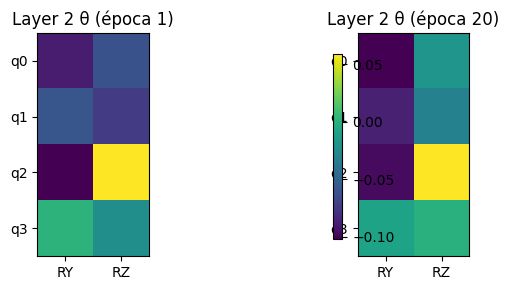

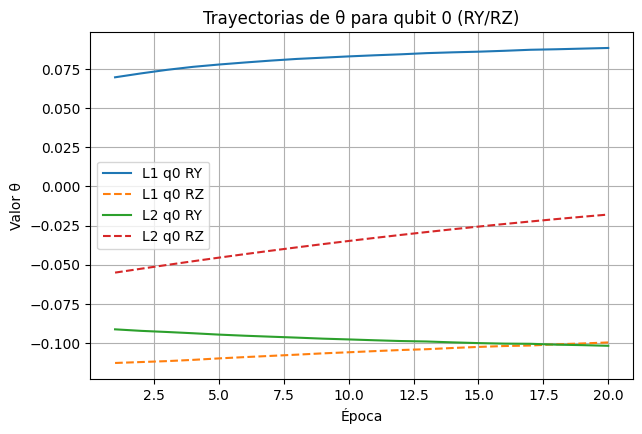

In [32]:
thetas = torch.stack(history_theta, dim=0).numpy()  # float32 CPU
E, L, Q, K = thetas.shape  # E, LAYERS, 4 qubits, 2 (RY,RZ)

theta_mean = thetas.mean(axis=(2,3))  # (E, L)
theta_std  = thetas.std(axis=(2,3))   # (E, L)

plt.figure(figsize=(7,4.5))
for l in range(L):
    plt.plot(np.arange(1,E+1), theta_mean[:,l], label=f"Layer {l+1} mean")
plt.xlabel("Época"); plt.ylabel("Media θ"); plt.title("Evolución de la media de θ por capa")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4.5))
for l in range(L):
    plt.plot(np.arange(1,E+1), theta_std[:,l], label=f"Layer {l+1} std")
plt.xlabel("Época"); plt.ylabel("STD θ"); plt.title("Evolución de la dispersión de θ por capa")
plt.grid(True); plt.legend(); plt.show()

def plot_heatmaps_layer(t0, tE, layer_idx):
    # t*: (4,2) → aplanamos a (8,) y también mostramos como 4×2
    fig, axs = plt.subplots(1, 2, figsize=(7,3))
    im0 = axs[0].imshow(t0, cmap='viridis'); axs[0].set_title(f"Layer {layer_idx+1} θ (época 1)")
    im1 = axs[1].imshow(tE, cmap='viridis'); axs[1].set_title(f"Layer {layer_idx+1} θ (época {E})")
    for ax in axs:
        ax.set_xticks([0,1]); ax.set_xticklabels(["RY","RZ"])
        ax.set_yticks([0,1,2,3]); ax.set_yticklabels([f"q{q}" for q in range(4)])
    fig.colorbar(im1, ax=axs.ravel().tolist(), shrink=0.8)
    plt.tight_layout(); plt.show()

for l in range(L):
    plot_heatmaps_layer(thetas[0,l], thetas[-1,l], l)

plt.figure(figsize=(7,4.5))
for l in range(L):
    plt.plot(np.arange(1,E+1), thetas[:,l,0,0], label=f"L{l+1} q0 RY")
    plt.plot(np.arange(1,E+1), thetas[:,l,0,1], '--', label=f"L{l+1} q0 RZ")
plt.xlabel("Época"); plt.ylabel("Valor θ"); plt.title("Trayectorias de θ para qubit 0 (RY/RZ)")
plt.grid(True); plt.legend(); plt.show()


# 10) Modelo clásico equivalente (Conv2D 2×2 + HeadSmall)

10.1) Capa convolucional clásica (imitando Quanv SAME-28)

In [33]:
class ClassicalConv2x2_28(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=4,
            kernel_size=2,
            stride=1,
            padding=0,  # padding manual para imitar SAME-28 del modelo cuántico
            bias=True
        )

    def forward(self, x):
        # Padding asimétrico EXACTO del modelo cuántico
        xpad = F.pad(x, (0,1,0,1), mode="constant", value=0.0)  # (B,1,29,29)
        return self.conv(xpad)  # (B,4,28,28)

10.2) Ensamble clásico completo

In [34]:
class ClassicalModel(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.conv = ClassicalConv2x2_28()
        self.head = HeadSmall(p_dropout=p_dropout)

    def forward(self, x):
        z = self.conv(x)
        return self.head(z)

def build_classical_model(p_dropout=DROPOUT_P):
    return ClassicalModel(p_dropout=p_dropout).to(DEVICE)

10.3) Crear instancia del modelo + conteo de parámetros

In [35]:
classical_model = build_classical_model()

print("Modelo clásico: 28×28 (Conv2D 2×2 SAME + Head 28×28)")
print("Parámetros totales (clásico):", sum(p.numel() for p in classical_model.parameters()))

Modelo clásico: 28×28 (Conv2D 2×2 SAME + Head 28×28)
Parámetros totales (clásico): 200853


10.4) Criterio y optimizador (idéntico al cuántico)

In [36]:
criterion_cl = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=DEVICE)
)

optimizer_cl = torch.optim.Adam(
    classical_model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

10.5) Funciones de entrenamiento / validación (versión clásica)

In [38]:
def train_epoch_cl(dloader):
    classical_model.train()
    tot_loss = 0.0
    tot_acc  = 0.0
    tot_n    = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)

        logits = classical_model(xb).view(-1)
        loss   = criterion_cl(logits, yb)

        optimizer_cl.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(classical_model.parameters(), 1.0)
        optimizer_cl.step()

        preds = (logits >= 0).float()
        acc   = (preds == yb).float().mean().item()

        B = xb.shape[0]
        tot_loss += loss.item() * B
        tot_acc  += acc * B
        tot_n    += B

    return tot_loss / tot_n, tot_acc / tot_n


@torch.no_grad()
def eval_epoch_cl(dloader):
    classical_model.eval()
    tot_loss = 0.0
    tot_n    = 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)

        logits = classical_model(xb).view(-1)
        loss   = criterion_cl(logits, yb)

        B = xb.shape[0]
        tot_loss += loss.item() * B
        tot_n    += B

        # guardamos todo en CPU para evitar problemas con numpy()
        logits_all.append(logits.detach().cpu())
        y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / tot_n

    # ahora todo está en CPU
    logits = torch.cat(logits_all).float()        # (N,)
    y_true = torch.cat(y_all).numpy()             # (N,)
    probs  = torch.sigmoid(logits).numpy()        # (N,)

    thr_star = _best_threshold(y_true, probs)
    y_hatS   = (probs >= thr_star).astype(int)

    accS = accuracy_score(y_true, y_hatS)
    aucS = roc_auc_score(y_true, probs)
    f1S  = f1_score(y_true, y_hatS)

    y_hat05 = (probs >= 0.5).astype(int)
    acc05   = accuracy_score(y_true, y_hat05)
    f105    = f1_score(y_true, y_hat05)

    return avg_loss, accS, aucS, f1S, thr_star, acc05, f105


# ---- Loop de entrenamiento clásico ----
history_cl = {
    "tr_loss": [], "tr_acc": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [],  "va_f105": []
}

best_val_loss_cl = float("inf")
best_state_cl    = None
best_thr_cl      = 0.5

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch_cl(train_loader)
    va_loss, acc_thr, auc_thr, f1_thr, thr_star, acc05, f105 = eval_epoch_cl(val_loader)

    if va_loss < best_val_loss_cl:
        best_val_loss_cl = va_loss
        best_state_cl    = {k: v.cpu().clone() for k, v in classical_model.state_dict().items()}
        best_thr_cl      = thr_star

    history_cl["tr_loss"].append(tr_loss)
    history_cl["tr_acc"].append(tr_acc)
    history_cl["va_loss"].append(va_loss)
    history_cl["va_auc"].append(auc_thr)
    history_cl["va_acc_thr"].append(acc_thr)
    history_cl["va_f1_thr"].append(f1_thr)
    history_cl["va_thr"].append(thr_star)
    history_cl["va_acc05"].append(acc05)
    history_cl["va_f105"].append(f105)

    print(f"[CLÁSICO] Época {ep:02d} | "
          f"Train: loss={tr_loss:.4f}, acc={tr_acc*100:.1f}% "
          f"| Val: loss={va_loss:.4f}, acc@thr*={acc_thr*100:.1f}%, AUC={auc_thr:.3f}")

[CLÁSICO] Época 01 | Train: loss=0.3214, acc=78.0% | Val: loss=0.3094, acc@thr*=85.5%, AUC=0.927
[CLÁSICO] Época 02 | Train: loss=0.2965, acc=84.3% | Val: loss=0.2857, acc@thr*=85.9%, AUC=0.936
[CLÁSICO] Época 03 | Train: loss=0.2735, acc=85.8% | Val: loss=0.2638, acc@thr*=87.4%, AUC=0.946
[CLÁSICO] Época 04 | Train: loss=0.2503, acc=86.7% | Val: loss=0.2419, acc@thr*=87.8%, AUC=0.953
[CLÁSICO] Época 05 | Train: loss=0.2294, acc=88.4% | Val: loss=0.2214, acc@thr*=92.0%, AUC=0.958
[CLÁSICO] Época 06 | Train: loss=0.2110, acc=88.7% | Val: loss=0.2042, acc@thr*=91.2%, AUC=0.961
[CLÁSICO] Época 07 | Train: loss=0.1959, acc=88.5% | Val: loss=0.1891, acc@thr*=92.0%, AUC=0.964
[CLÁSICO] Época 08 | Train: loss=0.1818, acc=89.5% | Val: loss=0.1759, acc@thr*=92.2%, AUC=0.967
[CLÁSICO] Época 09 | Train: loss=0.1703, acc=89.8% | Val: loss=0.1655, acc@thr*=92.9%, AUC=0.969
[CLÁSICO] Época 10 | Train: loss=0.1609, acc=90.2% | Val: loss=0.1555, acc@thr*=92.9%, AUC=0.970
[CLÁSICO] Época 11 | Train: lo

10.6) Gráficas del modelo clásico

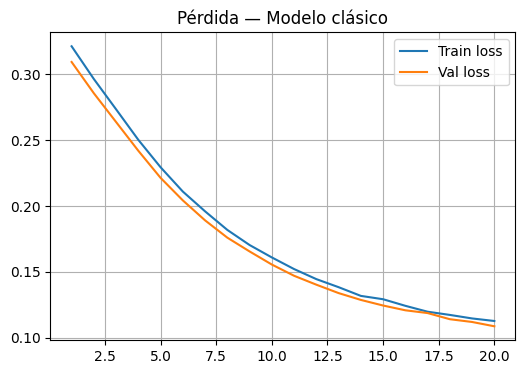

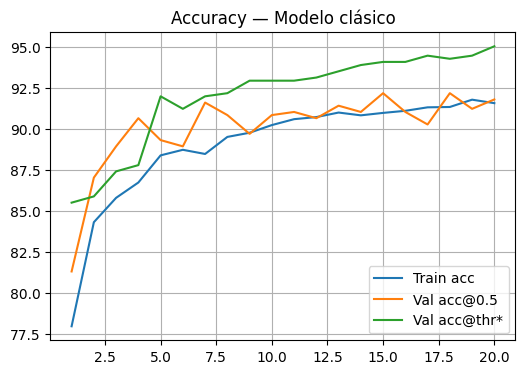

In [39]:
ep = np.arange(1, len(history_cl["tr_loss"])+1)

plt.figure(figsize=(6,4))
plt.plot(ep, history_cl["tr_loss"], label="Train loss")
plt.plot(ep, history_cl["va_loss"], label="Val loss")
plt.legend(); plt.grid(); plt.title("Pérdida — Modelo clásico")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ep, np.array(history_cl["tr_acc"])*100, label="Train acc")
plt.plot(ep, np.array(history_cl["va_acc05"])*100, label="Val acc@0.5")
plt.plot(ep, np.array(history_cl["va_acc_thr"])*100, label="Val acc@thr*")
plt.legend(); plt.grid(); plt.title("Accuracy — Modelo clásico")
plt.show()

10.7) Evaluación en TEST clásico

In [42]:
@torch.no_grad()
def eval_test_full(dloader, threshold):
    model_eval = classical_model   # <--- aquí se usa el modelo clásico
    model_eval.eval()

    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float().view(-1)

        logits = model_eval(xb).view(-1)
        loss   = criterion_cl(logits, yb)

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_n    += B

        logits_all.append(logits.cpu())
        y_all.append(yb.cpu())

    avg_loss = tot_loss / tot_n

    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()
    y_hat  = (probs >= float(threshold)).astype(int)

    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_hat, average="binary", zero_division=0
    )
    auc  = roc_auc_score(y_true, probs)
    prau = average_precision_score(y_true, probs)

    cm   = confusion_matrix(y_true, y_hat)
    rep  = classification_report(
        y_true, y_hat, target_names=["Sano(0)", "Neumonía(1)"], zero_division=0
    )

    return {
        "loss": avg_loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1,
        "auc": auc, "prauc": prau, "cm": cm, "report": rep, "thr": float(threshold)
    }


def _print_test_result(tag, res):
    print(f"\n[TEST {tag}] thr={res['thr']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.1f}% | "
          f"precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['prauc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("\nReporte por clase:\n", res["report"])

# Restaurar mejor estado
if best_state_cl is not None:
    classical_model.load_state_dict(best_state_cl)
    classical_model.to(DEVICE)

print(f"[CLÁSICO] Mejor val_loss={best_val_loss_cl:.4f}, thr*={best_thr_cl:.3f}")

res_cl_05 = eval_test_full(test_loader, 0.5)
res_cl_ts = eval_test_full(test_loader, best_thr_cl)

_print_test_result("[CLÁSICO] @0.5", res_cl_05)
_print_test_result("[CLÁSICO] @thr*", res_cl_ts)


[CLÁSICO] Mejor val_loss=0.1086, thr*=0.351

[TEST [CLÁSICO] @0.5] thr=0.500
loss=0.2674 | acc=86.5% | precision=0.871 | recall=0.921 | F1=0.895
AUC=0.918 | PR-AUC=0.925
Matriz de confusión:
 [[181  53]
 [ 31 359]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.85      0.77      0.81       234
 Neumonía(1)       0.87      0.92      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.86      0.87      0.86       624


[TEST [CLÁSICO] @thr*] thr=0.351
loss=0.2674 | acc=84.5% | precision=0.823 | recall=0.956 | F1=0.885
AUC=0.918 | PR-AUC=0.925
Matriz de confusión:
 [[154  80]
 [ 17 373]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.90      0.66      0.76       234
 Neumonía(1)       0.82      0.96      0.88       390

    accuracy                           0.84       624
   macro avg       0.86   